In [ ]:
import dataclasses
import numpy as np
import pandas as pd
import torch
from google.colab import drive

In [ ]:
%shell pip install py3dmol
import py3Dmol

In [ ]:
#@title Data utils
atom_types = [
    'N', 'CA', 'C', 'CB', 'O', 'CG', 'CG1', 'CG2', 'OG', 'OG1', 'SG', 'CD',
    'CD1', 'CD2', 'ND1', 'ND2', 'OD1', 'OD2', 'SD', 'CE', 'CE1', 'CE2', 'CE3',
    'NE', 'NE1', 'NE2', 'OE1', 'OE2', 'CH2', 'NH1', 'NH2', 'OH', 'CZ', 'CZ2',
    'CZ3', 'NZ', 'OXT'
]

restypes = [
    'A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H', 'I', 'L', 'K', 'M', 'F', 'P',
    'S', 'T', 'W', 'Y', 'V'
]
restype_order = {restype: i for i, restype in enumerate(restypes)}
restype_num = len(restypes)  # := 20.

restype_1to3 = {
    'A': 'ALA',
    'R': 'ARG',
    'N': 'ASN',
    'D': 'ASP',
    'C': 'CYS',
    'Q': 'GLN',
    'E': 'GLU',
    'G': 'GLY',
    'H': 'HIS',
    'I': 'ILE',
    'L': 'LEU',
    'K': 'LYS',
    'M': 'MET',
    'F': 'PHE',
    'P': 'PRO',
    'S': 'SER',
    'T': 'THR',
    'W': 'TRP',
    'Y': 'TYR',
    'V': 'VAL',
}

def make_np_example(coords_dict, seq_dict):
    """Make a dictionary of non-batched numpy protein features."""
    bb_atom_types = ['N', 'CA', 'C', 'O']
    bb_idx = [i for i, atom_type in enumerate(atom_types)
              if atom_type in bb_atom_types]

    num_res = np.array(coords_dict['N']).shape[0]
    atom_positions = np.zeros([num_res, 37, 3], dtype=float)

    for i, atom_type in enumerate(atom_types):
        if atom_type in bb_atom_types:
            atom_positions[:, i, :] = np.array(coords_dict[atom_type])

    # Mask nan / None coordinates.
    nan_pos = np.isnan(atom_positions)[..., 0]
    atom_positions[nan_pos] = 0.
    atom_mask = np.zeros([num_res, 37])
    atom_mask[..., bb_idx] = 1
    atom_mask[nan_pos] = 0

    batch = {
        'atom_positions': atom_positions,
        'atom_mask': atom_mask,
        'residue_index': np.arange(num_res),
    }

    #edited the code to pass also the amino acid sequence
    return batch, seq_dict


def make_fixed_size(np_example, max_seq_length=500):
    """Pad features to fixed sequence length, i.e. currently axis=0."""
    for k, v in np_example.items():
        if k != 'seq':
          pad = max_seq_length - v.shape[0]
          if pad > 0:
              v = np.pad(v, ((0, pad),) + ((0, 0),) * (len(v.shape) - 1))
          elif pad < 0:
              v = v[:max_seq_length]
          np_example[k] = v


def center_positions(np_example):
  """Center 'atom_positions' on CA center of mass."""
  atom_positions = np_example['atom_positions']
  atom_mask = np_example['atom_mask']
  ca_positions = atom_positions[:, 1, :]
  ca_mask = atom_mask[:, 1]

  ca_center = (np.sum(ca_mask[..., None] * ca_positions, axis=0) /
   (np.sum(ca_mask, axis=0) + 1e-9))
  atom_positions = ((atom_positions - ca_center[None, ...]) *
                    atom_mask[..., None])
  np_example['atom_positions'] = atom_positions


class DatasetFromDataframe(torch.utils.data.Dataset):
    """Load coordinates data from a DataFrame, currently from the 'coords' column."""

    def __init__(self, data_frame, max_seq_length=512):
        self.data = data_frame
        self.max_seq_length = max_seq_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        coords_dict = self.data.iloc[idx].coords
        seq_dict = self.data.iloc[idx].seq

        #passing both coordinates and sequence
        np_example, seq = make_np_example(coords_dict, seq_dict)
        make_fixed_size(np_example, self.max_seq_length)
        center_positions(np_example)
        #normalize_coords(np_example) #added by me
        example = {k: torch.tensor(v, dtype=torch.float32) for k, v
                   in np_example.items()}
        return example, seq


# Complete sequence of chain IDs supported by the PDB format.
PDB_CHAIN_IDS = 'ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz0123456789'
PDB_MAX_CHAINS = len(PDB_CHAIN_IDS)  # := 62.


@dataclasses.dataclass(frozen=True)
class Protein:
  """Protein structure representation."""

  # Cartesian coordinates of atoms in angstroms. The atom types correspond to
  # residue_constants.atom_types, i.e. the first three are N, CA, CB.
  atom_positions: np.ndarray  # [num_res, num_atom_type, 3]

  # Amino-acid type for each residue represented as an integer between 0 and
  # 20, where 20 is 'X'.
  aatype: np.ndarray  # [num_res]

  # Binary float mask to indicate presence of a particular atom. 1.0 if an atom
  # is present and 0.0 if not. This should be used for loss masking.
  atom_mask: np.ndarray  # [num_res, num_atom_type]

  # Residue index as used in PDB. It is not necessarily continuous or 0-indexed.
  residue_index: np.ndarray  # [num_res]

  # 0-indexed number corresponding to the chain in the protein that this residue
  # belongs to.
  chain_index: np.ndarray  # [num_res]

  # B-factors, or temperature factors, of each residue (in sq. angstroms units),
  # representing the displacement of the residue from its ground truth mean
  # value.
  b_factors: np.ndarray  # [num_res, num_atom_type]


def _chain_end(atom_index, end_resname, chain_name, residue_index) -> str:
  chain_end = 'TER'
  return (f'{chain_end:<6}{atom_index:>5}      {end_resname:>3} '
          f'{chain_name:>1}{residue_index:>4}')


def to_pdb(prot: Protein) -> str:
  """Converts a `Protein` instance to a PDB string.

  Args:
    prot: The protein to convert to PDB.

  Returns:
    PDB string.
  """
  restypes = [
    'A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H', 'I', 'L', 'K', 'M', 'F', 'P',
    'S', 'T', 'W', 'Y', 'V', 'X']
  res_1to3 = lambda r: restype_1to3.get(restypes[r], 'UNK')

  pdb_lines = []

  atom_mask = prot.atom_mask
  aatype = prot.aatype
  atom_positions = prot.atom_positions
  residue_index = prot.residue_index.astype(np.int32)
  chain_index = prot.chain_index.astype(np.int32)
  b_factors = prot.b_factors

  if np.any(aatype > restype_num):
    raise ValueError('Invalid aatypes.')

  # Construct a mapping from chain integer indices to chain ID strings.
  chain_ids = {}
  for i in np.unique(chain_index):  # np.unique gives sorted output.
    if i >= PDB_MAX_CHAINS:
      raise ValueError(
          f'The PDB format supports at most {PDB_MAX_CHAINS} chains.')
    chain_ids[i] = PDB_CHAIN_IDS[i]

  pdb_lines.append('MODEL     1')
  atom_index = 1
  last_chain_index = chain_index[0]
  # Add all atom sites.
  for i in range(aatype.shape[0]):
    # Close the previous chain if in a multichain PDB.
    if last_chain_index != chain_index[i]:
      pdb_lines.append(_chain_end(
          atom_index, res_1to3(aatype[i - 1]), chain_ids[chain_index[i - 1]],
          residue_index[i - 1]))
      last_chain_index = chain_index[i]
      atom_index += 1  # Atom index increases at the TER symbol.

    res_name_3 = res_1to3(aatype[i])
    for atom_name, pos, mask, b_factor in zip(
        atom_types, atom_positions[i], atom_mask[i], b_factors[i]):
      if mask < 0.5:
        continue

      record_type = 'ATOM'
      name = atom_name if len(atom_name) == 4 else f' {atom_name}'
      alt_loc = ''
      insertion_code = ''
      occupancy = 1.00
      element = atom_name[0]  # Protein supports only C, N, O, S, this works.
      charge = ''
      # PDB is a columnar format, every space matters here!
      atom_line = (f'{record_type:<6}{atom_index:>5} {name:<4}{alt_loc:>1}'
                   f'{res_name_3:>3} {chain_ids[chain_index[i]]:>1}'
                   f'{residue_index[i]:>4}{insertion_code:>1}   '
                   f'{pos[0]:>8.3f}{pos[1]:>8.3f}{pos[2]:>8.3f}'
                   f'{occupancy:>6.2f}{b_factor:>6.2f}          '
                   f'{element:>2}{charge:>2}')
      pdb_lines.append(atom_line)
      atom_index += 1

  # Close the final chain.
  pdb_lines.append(_chain_end(atom_index, res_1to3(aatype[-1]),
                              chain_ids[chain_index[-1]], residue_index[-1]))
  pdb_lines.append('ENDMDL')
  pdb_lines.append('END')

  # Pad all lines to 80 characters.
  pdb_lines = [line.ljust(80) for line in pdb_lines]
  return '\n'.join(pdb_lines) + '\n'  # Add terminating newline.

In [ ]:
#@title Load CATH data
drive.mount('/content/drive', force_remount=True)

print('Reading chain_set.jsonl, this can take 1 or 2 minutes...')
df = pd.read_json('/content/drive/MyDrive/CATHDATASET/chain_set.jsonl', lines=True)
cath_splits = pd.read_json('/content/drive/MyDrive/CATHDATASET/chain_set_splits.json', lines=True)
print('Read data.')

def get_split(pdb_name):
  if pdb_name in cath_splits.train[0]:
    return 'train'
  elif pdb_name in cath_splits.validation[0]:
    return 'validation'
  elif pdb_name in cath_splits.test[0]:
    return 'test'
  else:
    return 'None'

df['split'] = df.name.apply(lambda x: get_split(x))
df['seq_len'] = df.seq.apply(lambda x: len(x))

Mounted at /content/drive
Reading chain_set.jsonl, this can take 1 or 2 minutes...
Read data.


In [ ]:
#@title Make a data loader
class Config():
  def __init__(self):
    self.max_seq_length = 256
    self.batch_size = 64
    self.epochs = 100
    self.timestep = 1000
    self.max_coord_val = 134.06
    self.aa_emb_dim = 256
    self.lr = 1e-5
    self.model_checkpoint = "/content/drive/MyDrive/trained_model/checkpoint_epoch_100.pth"

cfg = Config()

#build train dataloader
train_set = DatasetFromDataframe(df[df.split == 'train'],
                                 max_seq_length=cfg.max_seq_length)

train_loader = torch.utils.data.DataLoader(train_set,
                                           batch_size=cfg.batch_size,
                                           drop_last = True,
                                           shuffle=True)

#build test dataloader
test_set = DatasetFromDataframe(df[df.split == 'test'],
                                 max_seq_length=cfg.max_seq_length)

test_loader = torch.utils.data.DataLoader(test_set,
                                           batch_size=cfg.batch_size,
                                           drop_last = True,
                                           shuffle = True)

In [ ]:
#@title Visualization example

# Pick a batch protein
batch, seq = next(train_iter)
np_batch = {k: v.detach().numpy() for k, v in batch.items()}

ix = 3

prot = Protein(
    atom_positions=np_batch['atom_positions'][ix],
    atom_mask=np_batch['atom_mask'][ix],
    residue_index=np_batch['residue_index'][ix],
    aatype=np.zeros([cfg.max_seq_length,], dtype=np.int32),
    chain_index=np.zeros([cfg.max_seq_length,], dtype=np.int32),
    b_factors=np.ones([cfg.max_seq_length, 37], dtype=np.int32)
)
pdb_str = to_pdb(prot)

# Render.
view = py3Dmol.view(
    width=600, height=600, linked=True , viewergrid=(1, 1))
view.setViewStyle({'style': 'outline', 'color': 'black', 'width': 0.1})
style = {"cartoon": {'color': 'spectrum'}}

view.addModelsAsFrames(pdb_str, viewer=(0, 0))
view.setStyle({'model': -1}, style, viewer=(0, 0))
view.zoomTo(viewer=(0, 0))

view.render()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [ ]:
#@title Data statistics

for split in ['train', 'test', 'val']:
  print(split + ' examples', len(df[df.split == split]))

print('')

for k, v in np_batch.items():
  print(k + ' shape', v.shape)


train examples 18024
test examples 1120
val examples 0

atom_positions shape (64, 256, 37, 3)
atom_mask shape (64, 256, 37)
residue_index shape (64, 256)


**Note on data features**

*  'atom_positions':

    Shape = [batch_size, number of residues or amino acids, number of atom types, coordinates].

    There are 37 possible different atom types in proteins. We want to restrict
    ourselves to the backbone atoms ['N', 'CA', 'C', 'O'], which are at index 0, 1,
    2 and 4 of axis 2 of the 'atom_positions' array. The positions of all other atom types are set to 0. For each protein in the batch, the positions are centered on the center of mass. In cases where the protein chain is shorter than 'max_seq_length', the sequence dimension (= axis 1) is padded with zeros to 'max_seq_length' length. In cases where the protein chain is larger than 'max_seq_length', the protein chain is cut off beyond 'max_seq_length'.

* 'atom_mask':

    Denotes which atoms have a known position. Non backbone atoms are masked, i.e. set to 0 in 'atom_mask', see above.

    Shape = [batch_size, number of residues or amino acids, number of atom types].

* 'residue_index':

    Shape = [batch_size, number of residues or amino acids].

    Is literally just arange(seq_length) and denotes the linearly increasing position of individual residues, so amino acids, along the protein chain.

In [ ]:
#@title YOUR MODEL, TRAINING & TEST CODE GOES HERE

In [ ]:
#copying the folder torchga into working directory. We'll use it to build our own layers
!cp -r /content/drive/MyDrive/torchga /content/

In [ ]:
import numpy as np
import torch
import math
import os
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchga.torchga import GeometricAlgebra
from torchga.layers import GeometricProductConv1D, TensorToGeometric
from torchga.layers import GeometricToTensor, GeometricProductDense
from torchga.layers import GeometricSandwichProductDense
import matplotlib.pyplot as plt
from diffusers import DDPMScheduler

torch.autograd.set_detect_anomaly(True)

In [ ]:
#@title Training utils

atom_positions = np_batch['atom_positions']
residue_index = np_batch['residue_index']

#we wish to focus only on N, CA, C and O atoms
def extract_backbone_coords(atom_positions):
  indices_to_keep = [0, 1, 2, 4]
  backbone_atom_positions = atom_positions[:, :, indices_to_keep, :]
  return torch.Tensor(backbone_atom_positions)


filtered_positions = extract_backbone_coords(atom_positions)
print("Filtered tensor shape (N, CA, C, O only): ", filtered_positions.shape)


#as specified from Data Utils above
amino_acid_vocab = {aa: idx for idx, aa in enumerate("ARNDCQEGHILKMFPSTWYVX")}

def initialize_aa_embeddings(amino_acid_vocab, embedding_dim):
    """
    Creates a fixed (non-learnable) embedding for amino acids.
    This should be initialized once and used throughout the training.

    Args:
        amino_acid_vocab (dict): Mapping of amino acids to unique indices.
        embedding_dim (int): Dimensionality of the embedding vector.

    Returns:
        torch.Tensor: A tensor of shape (vocab_size, embedding_dim) containing fixed embeddings.
    """
    vocab_size = len(amino_acid_vocab)

    # Initialize fixed amino acid embeddings (non-learnable)
    aa_embeddings = torch.randn(vocab_size, embedding_dim)  # Random embeddings
    aa_embeddings.requires_grad = False  # Disable learning on these embeddings

    return aa_embeddings

# Call this function once to initialize embeddings
aa_embeddings = initialize_aa_embeddings(amino_acid_vocab, embedding_dim=cfg.aa_emb_dim)

def create_amino_acid_positional_embedding(sequence, amino_acid_vocab, embedding_dim, aa_embeddings = aa_embeddings):
    """
    Creates a positional embedding for a sequence of amino acids, combining
    amino acid type and positional information.

    Args:
        sequence (str): Amino acid sequence (e.g., "ACDEFGHIK").
        amino_acid_vocab (dict): Mapping of amino acids to unique indices.
        embedding_dim (int): Dimensionality of the embedding vector.

    Returns:
        torch.Tensor: A tensor of shape (sequence_length, embedding_dim) containing
                      the combined amino acid and positional embeddings.
    """
    #Cropping sequence based on the maximum sequence length
    if len(sequence) > cfg.max_seq_length:
      sequence = sequence[:cfg.max_seq_length]

    # Initialize embeddings for amino acids
    vocab_size = len(amino_acid_vocab)

    # Initialize positional encoding
    sequence_length = len(sequence)
    position = torch.arange(0, sequence_length, dtype=torch.float).unsqueeze(1)  # Shape: (sequence_length, 1)
    div_term = torch.exp(torch.arange(0, embedding_dim, 2).float() * (-math.log(10000.0) / embedding_dim))
    positional_encoding = torch.zeros((sequence_length, embedding_dim))
    positional_encoding[:, 0::2] = torch.sin(position * div_term)
    positional_encoding[:, 1::2] = torch.cos(position * div_term)

    # Convert sequence to indices
    aa_indices = torch.tensor([amino_acid_vocab[aa] for aa in sequence], dtype=torch.long)  # Shape: (sequence_length,)

    # Get amino acid embeddings
    aa_embeddings = aa_embeddings[aa_indices]  # Shape: (sequence_length, embedding_dim)

    # Combine amino acid and positional embeddings (e.g., by summing or concatenating)
    combined_embedding = aa_embeddings + positional_encoding

    #padding
    if len(combined_embedding) < cfg.max_seq_length:
        padding = (0, 0, 0, cfg.max_seq_length - len(combined_embedding))  # (pad_left, pad_right, pad_top, pad_bottom)
        combined_embedding = F.pad(combined_embedding, padding, mode="constant", value=0)

    return combined_embedding


emb = create_amino_acid_positional_embedding(seq[1], amino_acid_vocab, 256)
print("Embedding shape: ", emb.shape)


def batch_create_amino_acid_positional_embedding(sequences, amino_acid_vocab, embedding_dim):

    embeddings = torch.zeros(len(sequences), cfg.max_seq_length, embedding_dim, dtype=torch.float32)

    for i, seq in enumerate(sequences):
        seq_embedding = create_amino_acid_positional_embedding(seq, amino_acid_vocab, embedding_dim)
        embeddings[i] = seq_embedding

    return embeddings


embs = batch_create_amino_acid_positional_embedding(seq, amino_acid_vocab, 256)
print("Batch embedding shape: ", embs.shape)


def sinusoidal_embedding(timestep, dim):
    half_dim = dim // 2
    freqs = torch.exp(-torch.arange(0, half_dim, 2).float() * math.log(10000) / half_dim).to(timestep.device)
    sinusoidal = torch.cat([torch.sin(timestep * freqs), torch.cos(timestep * freqs)], dim=-1)
    return sinusoidal

Filtered tensor shape (N, CA, C, O only):  torch.Size([64, 256, 4, 3])
Embedding shape:  torch.Size([256, 256])
Batch embedding shape:  torch.Size([64, 256, 256])


Distance map shape: torch.Size([64, 1024, 1024])


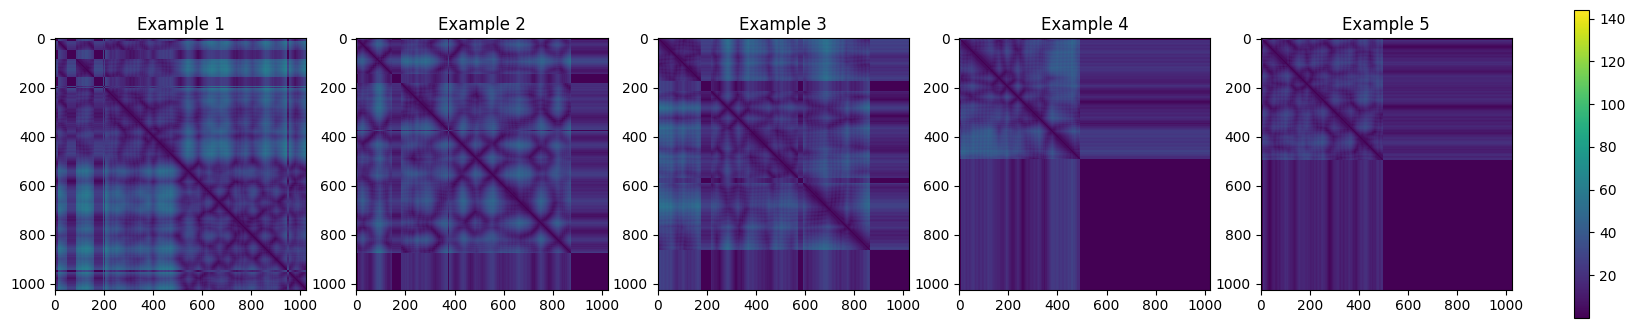

In [ ]:
#@title Metrics utils

#custom loss function: using MSE on distance maps
#Euclidean distance is invariant to rototranslations of the protein structure

def build_distance_map(atom_positions):

    #reshaping the atom coordinates as batch x total number of atoms x 3D coordiantes
    atom_positions = atom_positions.reshape((atom_positions.shape[0], atom_positions.shape[1]*4, 3))

    # Use broadcasting to get pairwise differences between points
    diff = atom_positions.unsqueeze(2) - atom_positions.unsqueeze(1)  # Shape: (batch_size, 1024, 1024, 3)

    # Calculate squared Euclidean distance
    squared_distances = torch.sum(diff**2, dim=-1)  # Shape: (batch_size, 1024, 1024)

    # Take square root to get the Euclidean distance
    distances = torch.sqrt(squared_distances + 1e-8)  # Shape: (batch_size, 1024, 1024)

    return distances


#Check if the plots are correct

distance_maps = build_distance_map(torch.Tensor(filtered_positions))
print("Distance map shape:", distance_maps.shape)


vmin = distance_maps.min().item()  # Minimum value across all maps
vmax = distance_maps.max().item()  # Maximum value across all maps

# Plot the first 5 distance maps side by side
plt.figure(figsize=(20, 4))  # Adjust figure size to make it wider

for i in range(5):
    distance_map_example = distance_maps[i].cpu().numpy()  # Convert to NumPy

    # Create a subplot for each distance map
    plt.subplot(1, 5, i+1)  # 1 row, 5 columns, i+1th plot
    img = plt.imshow(distance_map_example, cmap='viridis', interpolation='nearest', vmin=vmin, vmax=vmax)
    plt.title(f"Example {i+1}")


# Add a colorbar shared by all subplots
plt.colorbar(img, ax=plt.gcf().axes, orientation='vertical', fraction=0.02, pad=0.04)


#defining our custom loss
def MSE_loss_distance_map(estimated_coordinates, true_coordinates):

    #create distance maps
    estimated_distance_map = build_distance_map(estimated_coordinates)
    true_distance_map = build_distance_map(true_coordinates)

    return torch.mean((estimated_distance_map - true_distance_map) ** 2)


def align_coordinates(estimated_coordinates, true_coordinates):
    """
    Aligns estimated_coordinates to true_coordinates using the Kabsch algorithm.

    Args:
        estimated_coordinates (torch.Tensor): Tensor of shape (B, 4N, 3) representing estimated coordinates.
        true_coordinates (torch.Tensor): Tensor of shape (B, 4N, 3) representing true coordinates.

    Returns:
        torch.Tensor: Aligned estimated coordinates of shape (B, 4N, 3).
    """
    # Ensure shapes are consistent
    assert estimated_coordinates.shape == true_coordinates.shape, \
        "Shapes of estimated_coordinates and true_coordinates must match."

    B, _, _ = estimated_coordinates.shape

    # Center the coordinates around their respective centroids
    estimated_center = estimated_coordinates.mean(dim=1, keepdim=True)  # Shape: (B, 1, 3)
    true_center = true_coordinates.mean(dim=1, keepdim=True)            # Shape: (B, 1, 3)

    estimated_centered = estimated_coordinates - estimated_center  # Shape: (B, 4N, 3)
    true_centered = true_coordinates - true_center                 # Shape: (B, 4N, 3)

    # Compute covariance matrix
    covariance_matrices = torch.einsum('bij,bik->bjk', estimated_centered, true_centered)  # Shape: (B, 3, 3)

    # Singular Value Decomposition (SVD)
    U, S, Vt = torch.svd(covariance_matrices)  # Shapes: (B, 3, 3), (B, 3), (B, 3, 3)

    # Compute rotation matrix
    d = torch.det(U @ Vt.transpose(-2, -1))  # Shape: (B,)
    d = d.unsqueeze(-1).unsqueeze(-1)  # Shape: (B, 1, 1)
    identity = torch.eye(3, device=U.device).unsqueeze(0).repeat(B, 1, 1)  # Shape: (B, 3, 3)
    identity[:, -1, -1] = d.squeeze()  # Correct for reflection
    rotation_matrices = U @ identity @ Vt.transpose(-2, -1)  # Shape: (B, 3, 3)

    # Apply rotation to estimated coordinates
    aligned_coordinates = torch.einsum('bij,bkj->bki', estimated_centered, rotation_matrices)  # Shape: (B, 4N, 3)

    # Re-add the true centroid
    aligned_coordinates = aligned_coordinates.permute(0, 2, 1)
    aligned_coordinates = aligned_coordinates + true_center  # Shape: (B, 4N, 3)

    return aligned_coordinates

def compute_GDT_scores(estimated_coordinates, true_coordinates, thresholds_TS=[1.0, 2.0, 4.0, 8.0], thresholds_HA=[0.5, 1.0, 2.0, 4.0]):
    """
    Compute GDT_TS and GDT_HA scores for batches of estimated and true coordinates.

    Args:
        estimated_coordinates (torch.Tensor): Estimated atom coordinates, shape (B, N, 4, 3).
        true_coordinates (torch.Tensor): True atom coordinates, shape (B, N, 4, 3).
        thresholds_TS (list): Distance thresholds for GDT_TS computation.
        thresholds_HA (list): Distance thresholds for GDT_HA computation.

    Returns:
        torch.Tensor, torch.Tensor: GDT_TS scores, GDT_HA scores, both of shape (B, 1).
    """
    # Reshape input tensors to (B, 4N, 3)
    B, N, _, _ = estimated_coordinates.shape
    estimated_coordinates = estimated_coordinates.reshape(B, -1, 3)  # (B, 4N, 3)
    true_coordinates = true_coordinates.reshape(B, -1, 3)            # (B, 4N, 3)

    # Compute pairwise L2 distances

    estimated_coordinates = align_coordinates(estimated_coordinates, true_coordinates)
    distances = torch.norm(estimated_coordinates - true_coordinates, dim=-1)  # (B, 4N)

    # Compute GDT_TS: Average fraction of points within thresholds_TS
    gdt_ts_scores = []
    for threshold in thresholds_TS:
        within_threshold = (distances <= threshold).float()  # Binary mask (B, 4N)
        gdt_ts_scores.append(within_threshold.mean(dim=1, keepdim=True))  # Fraction within threshold (B, 1)

    GDT_TS = sum(gdt_ts_scores) / len(thresholds_TS)  # Average over thresholds (B, 1)

    # Compute GDT_HA: Average fraction of points within thresholds_HA
    gdt_ha_scores = []
    for threshold in thresholds_HA:
        within_threshold = (distances <= threshold).float()  # Binary mask (B, 4N)
        gdt_ha_scores.append(within_threshold.mean(dim=1, keepdim=True))  # Fraction within threshold (B, 1)

    GDT_HA = sum(gdt_ha_scores) / len(thresholds_HA)  # Average over thresholds (B, 1)

    return GDT_TS, GDT_HA

In [96]:
#@title Training step

#defining the noise scheduler. Clipping the range to the maximum value in the dataset
scheduler = DDPMScheduler(num_train_timesteps=cfg.timestep, clip_sample_range = 134.0)

def step(model, real_data, AA_sequences, device, scheduler, timesteps):
    atoms_positions = real_data["atom_positions"]

    #extract N, CA, C, O coordinates only
    filtered_atom_positions = extract_backbone_coords(atoms_positions)
    filtered_atom_positions = filtered_atom_positions.to(device)

    # Add noise to data for each timestep
    timestep = torch.randint(0, timesteps, (1,))

    pure_noise = torch.randn_like(filtered_atom_positions)
    noisy_data = scheduler.add_noise(filtered_atom_positions, pure_noise, timestep)

    # Generate timestep sinusoidal embedding
    timestep_tensor = torch.tensor([timestep], dtype=torch.float32, device=filtered_atom_positions.device)
    timestep_tensor = timestep_tensor.repeat(filtered_atom_positions.size(0), 1)  # Shape: (batch_size, 1)

    # Generate sinusoidal embedding for timestep
    timestep_sinusoidal_embedding = sinusoidal_embedding(timestep_tensor, dim = 512)  # Shape: (batch_size, timestep_embedding_dim)

    # Generate positional embedding
    positional_embedding = batch_create_amino_acid_positional_embedding(AA_sequences, amino_acid_vocab, embedding_dim=256).to(device)
    batch_size, max_seq_len, positional_embedding_dim = positional_embedding.shape

    # Expand timestep embedding to sequence length
    timestep_sinusoidal_expanded = timestep_sinusoidal_embedding.unsqueeze(1).repeat(1, max_seq_len, 1)  # Shape: (batch_size, max_seq_len, timestep_embedding_dim)

    # Concatenate positional embedding with timestep embedding
    condition = torch.cat([positional_embedding, timestep_sinusoidal_expanded], dim=-1)  # Shape: (batch_size, max_seq_len, positional_embedding_dim + timestep_embedding_dim)
    condition = condition.to(device)

    # Forward pass with condition
    estimated_noise = model(noisy_data, condition=condition)
    estimated_atom_positions = scheduler.step(estimated_noise, timestep, noisy_data).pred_original_sample

    # Compute loss & metrics
    loss = torch.nn.functional.mse_loss(estimated_noise, pure_noise)
    with torch.no_grad():
        distance_mse = MSE_loss_distance_map(estimated_atom_positions, filtered_atom_positions)
    gdt_ts, gdt_ha = compute_GDT_scores(estimated_atom_positions, filtered_atom_positions)


    return loss, distance_mse, gdt_ts, gdt_ha

In [ ]:
#@title Plotting utils

def plot_training_metrics(training_metrics):
    # Extract metrics
    loss = training_metrics['loss']
    gdt_ts = training_metrics['gdt_ts']
    gdt_ha = training_metrics['gdt_ha']
    dist_mse = training_metrics['dist_mse']
    steps = range(1, len(loss) + 1)  # Assume steps are sequential indices

    # Set up subplots
    fig, axs = plt.subplots(1, 4, figsize=(15, 5))

    # Plot Loss
    axs[0].plot(steps, loss, label="Loss", color="blue", linewidth = 2)
    axs[0].set_title("Training Loss")
    axs[0].set_xlabel("Steps")
    axs[0].set_ylabel("Loss")
    axs[0].legend()
    axs[0].grid()

    # Plot MSE
    axs[1].plot(steps, loss, label="MSE on distance maps", color="magenta", linewidth = 2)
    axs[1].set_title("MSE on distance maps")
    axs[1].set_xlabel("Steps")
    axs[1].set_ylabel("MSE")
    axs[1].legend()
    axs[1].grid()

    # Plot GDT-TS
    axs[2].plot(steps, gdt_ts, label="GDT_TS", color="green", linewidth = 2)
    axs[2].set_title("GDT_TS Score")
    axs[2].set_xlabel("Steps")
    axs[2].set_ylabel("GDT_TS")
    axs[2].legend()
    axs[2].grid()

    # Plot GDT-HA
    axs[3].plot(steps, gdt_ha, label="GDT_HA", color="red", linewidth = 2)
    axs[3].set_title("GDT_HA Score")
    axs[3].set_xlabel("Steps")
    axs[3].set_ylabel("GDT_HA")
    axs[3].legend()
    axs[3].grid()

    # Adjust layout and show
    plt.tight_layout()
    plt.show()

In [ ]:
#@title Defining the Geometric UNet backbone

class GeometricUNet(nn.Module):
    def __init__(self, in_channels=4, out_channels=4, condition_dim=256+1):
        super(GeometricUNet, self).__init__()

        #GA utils
        self.ga = GeometricAlgebra([1, 1, 1])
        self.scalar_indices = torch.tensor([0])
        self.vector_indices = torch.tensor([1, 2, 3])
        self.rotational_indices = torch.tensor([0, 4, 5, 6])
        self.full_indices = torch.arange(0, self.ga.num_blades)

        #Embedding layers
        self.tens2geom_vec = TensorToGeometric(self.ga, blade_indices=self.vector_indices)
        self.tens2geom_scal = TensorToGeometric(self.ga, blade_indices=self.scalar_indices)
        self.geom2tens = GeometricToTensor(self.ga, blade_indices=self.vector_indices)

        # Encoder
        self.enc1 = self.conv_block(in_channels, 64)
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 512)

        # Decoder
        self.dec3 = self.conv_block(512, 128)
        self.dec2 = self.conv_block(128, 64)
        self.dec1 = self.conv_block_out(64, in_channels)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            GeometricProductConv1D(self.ga, num_input_filters=in_channels,
                                   num_output_filters=out_channels,
                                   kernel_size=3,
                                   stride=1, padding="SAME",
                                   blade_indices_kernel=self.full_indices,
                                   blade_indices_bias=self.vector_indices),
            nn.GELU(),
            GeometricProductConv1D(self.ga, num_input_filters=out_channels,
                                   num_output_filters=out_channels,
                                   kernel_size=3,
                                   stride=1, padding="SAME",
                                   blade_indices_kernel=self.full_indices,
                                   blade_indices_bias=self.vector_indices),
            nn.GELU()

        )

    def conv_block_out(self, in_channels, out_channels):
        return nn.Sequential(
            GeometricProductConv1D(self.ga, num_input_filters=in_channels,
                                   num_output_filters=out_channels,
                                   kernel_size=3,
                                   stride=1, padding="SAME",
                                   blade_indices_kernel=self.full_indices,
                                   blade_indices_bias=self.vector_indices),
            nn.GELU(),
            GeometricProductConv1D(self.ga, num_input_filters=out_channels,
                                   num_output_filters=out_channels,
                                   kernel_size=3,
                                   stride=1, padding="SAME",
                                   blade_indices_kernel=self.full_indices,
                                   blade_indices_bias=self.vector_indices),

        )

    def forward(self, x, condition):

        x_geom = self.tens2geom_vec(x)

        enc1 = self.enc1(x_geom)
        enc2 = self.enc2(enc1)
        enc3 = self.enc3(enc2)

        condition = condition.unsqueeze(-1)
        condition_geom = self.tens2geom_scal(condition)

        enc3 = enc3 + condition_geom

        dec3 = self.dec3(enc3)
        dec2 = self.dec2(dec3 + enc2)
        out = self.dec1(dec2 + enc1)

        out = out.reshape((x.shape[0], -1, 4, 8))

        out = self.geom2tens(out)

        return out


# Example of how to initialize and use the model
batch_size = 64
seq_len = 256
n_atoms = 4
dims = 3


# Initialize the U-Net
geounet = GeometricUNet(in_channels=n_atoms, out_channels=n_atoms)

# Example input of shape [batch_size, seq_len, n_atoms, dims]
input_tensor = torch.randn(batch_size, seq_len, n_atoms, dims)

embedding_dim = 256
condition = torch.randn(batch_size, seq_len, embedding_dim*2)

# Forward pass
output_tensor = geounet(input_tensor, condition)
print(output_tensor.shape)  # Expected shape: [batch_size, seq_len, n_atoms, dims]

torch.Size([64, 256, 4, 3])


In [97]:
#@title Defining the sampling loop


def model_sample(model, test_data_loader,  timesteps = cfg.timestep, num_batches = 1000):
    """
    Test the diffusion model by generating output from noise conditioned on the sequence.

    Args:
        model_path (str): Path to the saved model checkpoint.
        test_data_loader (DataLoader): DataLoader providing test sequences.
        timesteps (int): Number of timesteps for the noise schedule.
    """

    device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')



    distance_maps_MSE = []
    GDT_TS = []
    GDT_HA = []
    generated_coordinates = []
    true_coordinates = []

    with torch.no_grad():
        for batch_idx, (real_data, AA_sequences) in enumerate(test_data_loader):  # Only need sequences for generation

            # Generate pure noise as the starting point
            batch_size = len(AA_sequences)
            max_seq_len = cfg.max_seq_length
            noisy_data = torch.randn(batch_size, max_seq_len, 4, 3).to(device)  # Shape: (B, N, 4, 3)
            #noisy_data = noisy_data.permute(0, 2, 1)  # Shape: (B, 3, 4N) (matching the UNet input)

            # Create positional embeddings
            positional_embedding = batch_create_amino_acid_positional_embedding(
                AA_sequences, amino_acid_vocab, embedding_dim=256
            )  # Shape: (B, N, 256)
            _, max_seq_len, _ = positional_embedding.shape

            # Iteratively denoise
            for t in range(timesteps - 1, -1, -1):
                # Generate timestep sinusoidal embedding
                timestep_tensor = torch.tensor([t], dtype=torch.float32, device=noisy_data.device)
                timestep_tensor = timestep_tensor.repeat(noisy_data.size(0), 1)  # Shape: (batch_size, 1)

                # Generate sinusoidal embedding for timestep
                timestep_sinusoidal_embedding = sinusoidal_embedding(timestep_tensor, dim = 512)  # Shape: (batch_size, timestep_embedding_dim)

                # Generate positional embedding
                positional_embedding = batch_create_amino_acid_positional_embedding(AA_sequences, amino_acid_vocab, embedding_dim=256).to(device)
                batch_size, max_seq_len, positional_embedding_dim = positional_embedding.shape

                # Expand timestep embedding to sequence length
                timestep_sinusoidal_expanded = timestep_sinusoidal_embedding.unsqueeze(1).repeat(1, max_seq_len, 1)  # Shape: (batch_size, max_seq_len, timestep_embedding_dim)

                # Concatenate positional embedding with timestep embedding
                condition = torch.cat([positional_embedding, timestep_sinusoidal_expanded], dim=-1)  # Shape: (batch_size, max_seq_len, positional_embedding_dim + timestep_embedding_dim)

                # Predict the noise (not the data)
                predicted_noise = model(noisy_data, condition=condition.to(device))  # Predict noise ε_t

                # Use DDPMScheduler's built-in step function
                # The scheduler will use the predicted noise and compute the next timestep's image (x_{t-1})
                #noisy_data is updated to x_{t-1} after the step
                noisy_data = scheduler.step(predicted_noise, t, noisy_data).prev_sample


            #Denormalisation
            estimated_atom_positions = noisy_data

            atoms_positions = real_data["atom_positions"]

            filtered_atom_positions = extract_backbone_coords(atoms_positions).to(device)

            distance_mse = MSE_loss_distance_map(estimated_atom_positions, filtered_atom_positions)
            total_score, half_size = compute_GDT_scores(estimated_atom_positions, filtered_atom_positions)
            distance_maps_MSE.append(distance_mse)
            GDT_TS.append(total_score)
            GDT_HA.append(half_size)

            generated_coordinates.append(estimated_atom_positions)
            true_coordinates.append(filtered_atom_positions)

            # Print or return the results for verification
            print(f"Sampling batch {batch_idx+1}: Distance MSE = {distance_mse.mean().item():.4f}, GDT_TS = {total_score.mean().item():.4f}, GDT_HA = {half_size.mean().item():.4f}")

            if batch_idx +1 > num_batches:
              break



    print("Evaluation completed.")
    return generated_coordinates, true_coordinates
    #return generated_coordinates, true_coordinates

In [ ]:
#@title Defining the training loop

def model_train(model, train_data_loader, val_data_loader, scheduler, num_epochs=cfg.epochs, timesteps=cfg.timestep):

    device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    optimizer = optim.Adam(model.parameters(), lr=cfg.lr)

    # To store loss and GDT scores
    training_metrics = {'loss': [], 'gdt_ts': [], 'gdt_ha': [], 'dist_mse': []}
    validation_metrics = {'loss': [], 'gdt_ts': [], 'gdt_ha': [], 'dist_mse': []}
    best_val_loss = 10e9


    for epoch in range(num_epochs):
        model.train()

        total_loss = 0
        total_gdt_ts_score = 0
        total_gdt_ha_score = 0
        total_distance_mse = 0

        for batch_idx, (real_data, AA_sequences) in enumerate(train_data_loader):

            loss, distance_mse, gdt_ts, gdt_ha = step(model, real_data, AA_sequences, device, scheduler, timesteps)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            total_distance_mse += distance_mse.mean().item()
            total_gdt_ts_score += gdt_ts.mean().item()
            total_gdt_ha_score += gdt_ha.mean().item()


            #print training metrics every 50 batches
            if (batch_idx + 1) % 50 == 0:
                avg_loss = total_loss / (batch_idx + 1)
                avg_mse = total_distance_mse / (batch_idx + 1)
                avg_gdt_ts = total_gdt_ts_score / (batch_idx + 1)
                avg_gdt_ha = total_gdt_ha_score / (batch_idx + 1)
                print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(train_data_loader)}], Loss: {avg_loss:.4f}, Dist_MSE: {avg_mse:.2f}, GDT_TS: {avg_gdt_ts:.4f}, GDT_HA: {avg_gdt_ha:.4f}")

                training_metrics['loss'].append(avg_loss)
                training_metrics['dist_mse'].append(avg_mse)
                training_metrics['gdt_ts'].append(avg_gdt_ts)
                training_metrics['gdt_ha'].append(avg_gdt_ha)

        # Validation loop (after each epoch)
        model.eval()  # Set model to evaluation mode
        val_loss = 0
        val_dist_mse = 0
        val_gdt_ts_score = 0
        val_gdt_ha_score = 0

        with torch.no_grad():  # Disable gradient calculation during validation
            for batch_idx, (real_data, AA_sequences) in enumerate(val_data_loader):

                loss, distance_mse, gdt_ts, gdt_ha = step(model, real_data, AA_sequences, device, scheduler, timesteps)

                val_loss += loss.item()
                val_dist_mse += distance_mse.mean().item()
                val_gdt_ts_score += gdt_ts.mean().item()
                val_gdt_ha_score += gdt_ha.mean().item()

        # Average validation metrics
        avg_val_loss = val_loss / len(val_data_loader)
        avg_val_mse = val_dist_mse / len(val_data_loader)
        avg_val_gdt_ts = val_gdt_ts_score / len(val_data_loader)
        avg_val_gdt_ha = val_gdt_ha_score / len(val_data_loader)

        # Store validation metrics
        validation_metrics['loss'].append(avg_val_loss)
        validation_metrics['dist_mse'].append(avg_val_mse)
        validation_metrics['gdt_ts'].append(avg_val_gdt_ts)
        validation_metrics['gdt_ha'].append(avg_val_gdt_ha)


        print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {total_loss/len(train_data_loader):.4f}, Val Loss: {avg_val_loss:.4f}, Val dist MSE: {avg_val_mse:.2f}, Val GDT_TS: {avg_val_gdt_ts:.4f}, Val GDT_HA: {avg_val_gdt_ha:.4f}")

        # Save model checkpoint after each batch or epoch
        if avg_val_loss < best_val_loss:
          path = os.getcwd()
          save_path = os.path.join(path, "drive/MyDrive/trained_model/")

          torch.save({
              'epoch': epoch + 1,
              'model_state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              'loss': total_loss / len(train_data_loader),
          }, save_path + f'checkpoint_epoch_{epoch+1}.pth')

          best_val_loss = avg_val_loss
          print("Found a new best - saved as 'checkpoint_epoch_", epoch+1, ".pth'")


        if (epoch+1) % 5 == 0:
          print("Sampling...")
          _ , _ = model_sample(model, val_data_loader, num_batches = 1)


    return training_metrics, validation_metrics


Epoch [1/100], Batch [50/281], Loss: 0.9988, Dist_MSE: 4713.37, GDT_TS: 0.3562, GDT_HA: 0.2577
Epoch [1/100], Batch [100/281], Loss: 0.9969, Dist_MSE: 4890.45, GDT_TS: 0.3896, GDT_HA: 0.2962
Epoch [1/100], Batch [150/281], Loss: 0.9941, Dist_MSE: 3629.51, GDT_TS: 0.4280, GDT_HA: 0.3181
Epoch [1/100], Batch [200/281], Loss: 0.9875, Dist_MSE: 3993.98, GDT_TS: 0.3979, GDT_HA: 0.2886
Epoch [1/100], Batch [250/281], Loss: 0.9807, Dist_MSE: 4031.68, GDT_TS: 0.4055, GDT_HA: 0.2936
Epoch [1/100], Training Loss: 0.9767, Val Loss: 0.9362, Val dist MSE: 4417.39, Val GDT_TS: 0.4717, Val GDT_HA: 0.3307
Found a new best - saved as 'checkpoint_epoch_ 1 .pth'
Epoch [2/100], Batch [50/281], Loss: 0.9214, Dist_MSE: 1949.00, GDT_TS: 0.3910, GDT_HA: 0.2501
Epoch [2/100], Batch [100/281], Loss: 0.9106, Dist_MSE: 2021.51, GDT_TS: 0.3919, GDT_HA: 0.2621
Epoch [2/100], Batch [150/281], Loss: 0.8968, Dist_MSE: 2641.71, GDT_TS: 0.3523, GDT_HA: 0.2308
Epoch [2/100], Batch [200/281], Loss: 0.8907, Dist_MSE: 2589.

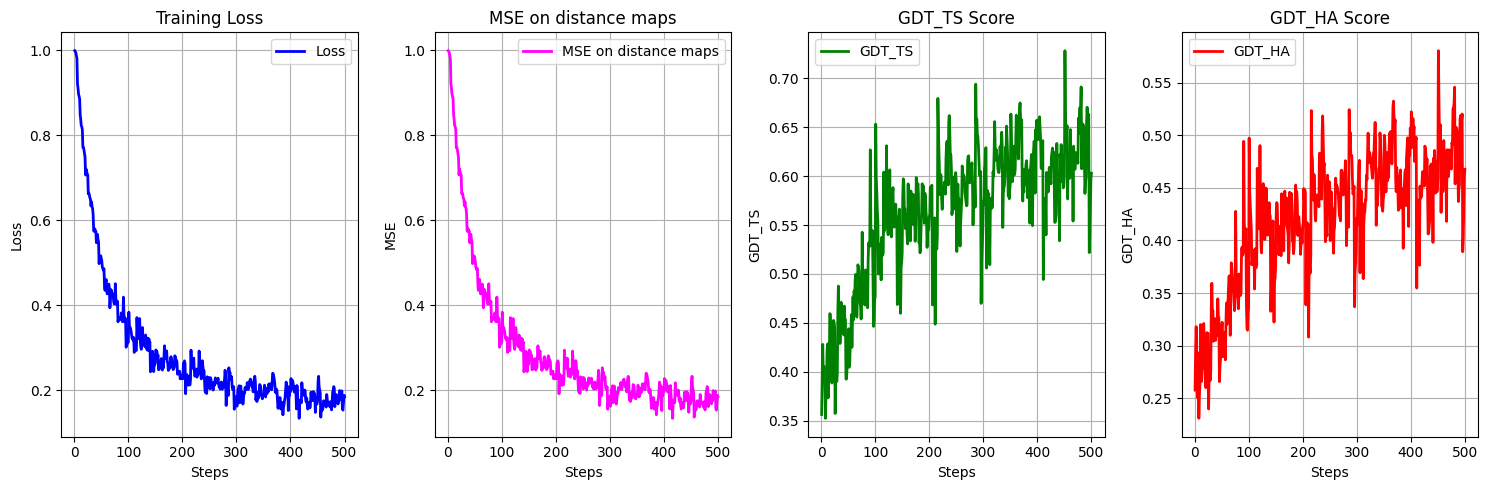

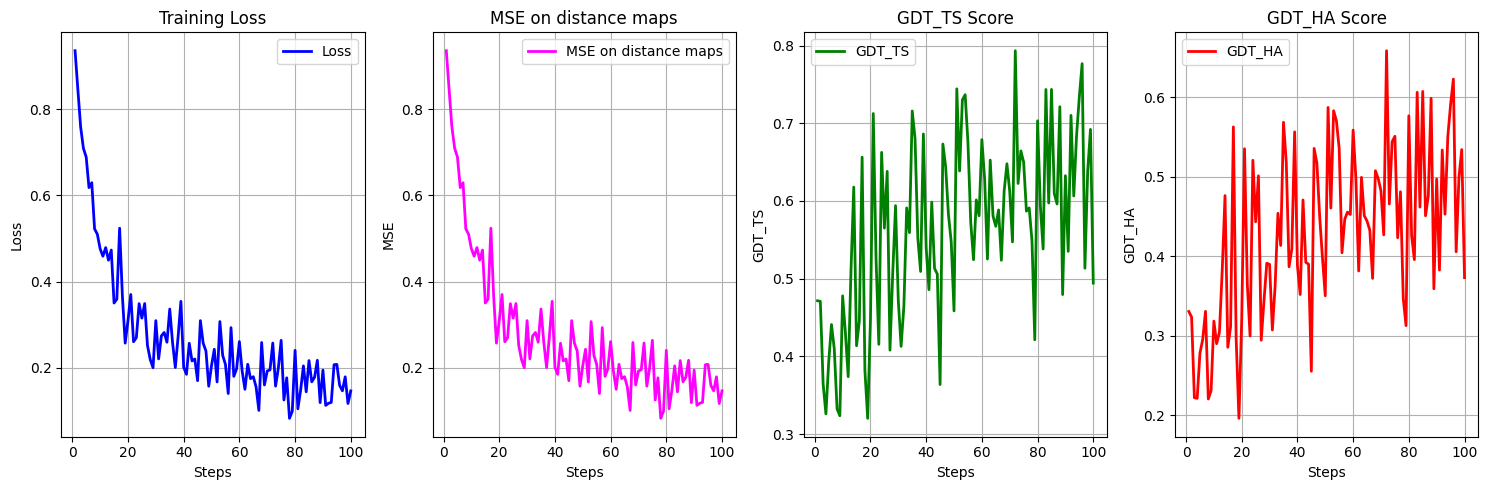

In [54]:
#@title TRAINING

training_metrics, validation_metrics = model_train(geounet, train_loader, test_loader, scheduler)

torch.save(training_metrics, "drive/MyDrive/trained_model/training_metrics.pth")
torch.save(validation_metrics, "drive/MyDrive/trained_model/validation_metrics.pth")

plot_training_metrics(training_metrics)
plot_training_metrics(validation_metrics)

#training_metrics =torch.load("drive/MyDrive/trained_model/training_metrics.pth")
#plot_training_metrics(training_metrics)

In [58]:
#storing the final model

path = os.getcwd()
save_path = os.path.join(path, "drive/MyDrive/trained_model/")

torch.save({
    'model_state_dict': geounet.state_dict(),
}, save_path + 'checkpoint_epoch_100.pth')

In [98]:
#@title SAMPLING

#generate two batches of the test set and save them
generated_coordinates, true_coordinates = model_sample(geounet, test_loader, num_batches = 1)

torch.save(generated_coordinates, "drive/MyDrive/trained_model/generated_coordinates.pth")
torch.save(true_coordinates, "drive/MyDrive/trained_model/true_coordinates.pth")

Sampling batch 1: Distance MSE = 243.1847, GDT_TS = 0.1592, GDT_HA = 0.0701
Sampling batch 2: Distance MSE = 251.0088, GDT_TS = 0.1826, GDT_HA = 0.0915
Evaluation completed.


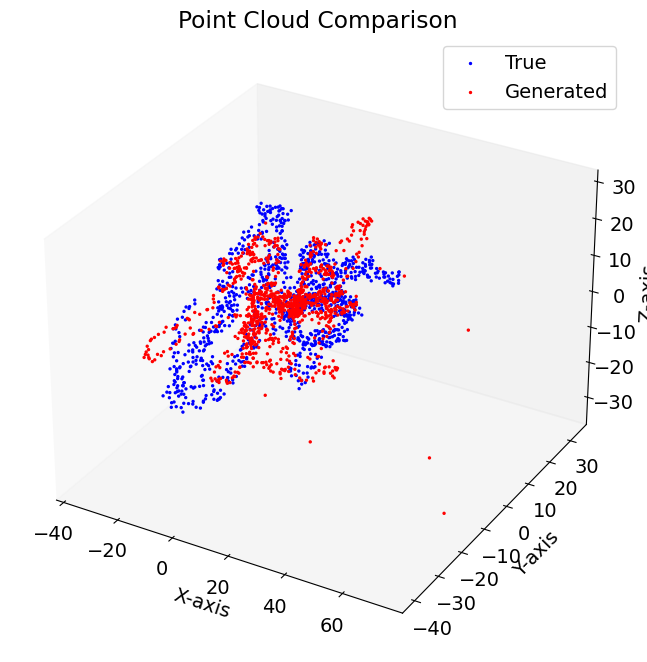

In [91]:
#@title Plotting examples

idx = 31

plt.rcParams.update({'font.size': 14})

gen_coords = generated_coordinates[0].reshape(64, -1, 3).cpu().numpy()  # Shape: (4N, 3)
true_coords = true_coordinates[0].reshape(64, -1, 3).cpu().numpy()      # Shape: (4N, 3)

gen_coords = gen_coords[idx]
true_coords = true_coords[idx]

gen_coords  = align_coordinates(torch.tensor(gen_coords).unsqueeze(0) , torch.tensor(true_coords).unsqueeze(0)).squeeze()
# Create the figure and 3D axis
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')


# Plot the true coordinates
ax.scatter(true_coords[:, 0], true_coords[:, 1], true_coords[:, 2],
            color='blue', label='True', alpha=1, s=2)


# Plot the generated coordinates
ax.scatter(gen_coords[:, 0], gen_coords[:, 1], gen_coords[:, 2],
            color='red', label='Generated', alpha=1, s=2)

# Add labels and legend
ax.set_title("Point Cloud Comparison")
ax.set_xlabel("X-axis")
ax.set_ylabel("Y-axis")
ax.set_zlabel("Z-axis")
ax.legend()
ax.grid(False)
# Show the plot
plt.show()